In [56]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
import do_mpc
import pandas as pd
from sklearn import linear_model, model_selection
import os

In [57]:
%matplotlib notebook

In [58]:
file_list = os.listdir('./results/')
n_res = len(file_list)


In [59]:
nn_input_list = []
nn_output_list = []
for file_i in file_list:
    res = do_mpc.data.load_results('./results/'+file_i)

    phi = res['simulator']['_x', 'phi'].flatten()
    theta = res['simulator']['_x', 'theta'].flatten()
    u_tilde = res['simulator']['_u', 'u_tilde'].flatten()
    psi = res['simulator']['_x', 'psi'].flatten()
    E_0 = res['simulator']['_p', 'E_0'].flatten()
    v_0 = res['simulator']['_p', 'v_0'].flatten()
        
    phi += 0.01*np.random.rand(phi.shape[0])
    theta += 0.01*np.random.rand(theta.shape[0])
    phi = np.roll(phi, -1)
    theta = np.roll(theta, -1)
    psi = np.roll(psi, -1)
    
    phi = phi[:-1]
    theta = theta[:-1]
    u_tilde = u_tilde[:-1]
    psi = psi[:-1]
    E_0 = E_0[:-1]
    v_0 = v_0[:-1]


    nn_input = {'phi':phi, 'theta': theta, 'u_tilde': u_tilde}
    nn_output = {'phi':phi, 'theta': theta, 'psi': psi,  'u_tilde': u_tilde, 'E_0': E_0, 'v_0': v_0}

    nn_input_df = pd.DataFrame.from_dict(nn_input)
    nn_output_df = pd.DataFrame.from_dict(nn_output)

    nn_input_list.append(nn_input_df)
    nn_output_list.append(nn_output_df)

# I/O structure


In [60]:
nn_input_train, nn_input_test, nn_output_train, nn_output_test = model_selection.train_test_split(nn_input_list, nn_output_list)

X_train = pd.concat(nn_input_train).to_numpy()
X_test = pd.concat(nn_input_test).to_numpy()

Y_train = pd.concat(nn_output_train).to_numpy()
Y_test = pd.concat(nn_output_test).to_numpy()

nx = X_train.shape[1]
ny = Y_train.shape[1]

# Scaling
Y_train_scaling = np.max(np.abs(Y_train), axis=0)
Y_train /= Y_train_scaling
Y_test /= Y_train_scaling

# Create DNN:

In [61]:
n_layer = 4          # This includes the output layer. n_layer-1 is the number of hidden layers.
n_units = 80         # Number of units per hidden layer.  
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nx
model_param['n_out'] = ny
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss='mse', optimizer='Adam')

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_16 (Dense)             (None, 80)                320       
_________________________________________________________________
dense_17 (Dense)             (None, 80)                6480      
_________________________________________________________________
dense_18 (Dense)             (None, 80)                6480      
_________________________________________________________________
dense_19 (Dense)             (None, 6)                 486       
Total params: 13,766
Trainable params: 13,766
Non-trainable params: 0
_________________________________________________________________


In [62]:
history = model.fit(X_train, 
                    Y_train,
                    validation_data = (X_test, Y_test),
                    batch_size=500, 
                    epochs=1000)

Train on 10485 samples, validate on 3495 samples
Epoch 1/1000
10485/10485 [==============================] - 0s 41us/sample - loss: 0.2389 - val_loss: 0.0796
Epoch 2/1000
10485/10485 [==============================] - 0s 9us/sample - loss: 0.0543 - val_loss: 0.0534
Epoch 3/1000
10485/10485 [==============================] - 0s 11us/sample - loss: 0.0402 - val_loss: 0.0483
Epoch 4/1000
10485/10485 [==============================] - 0s 12us/sample - loss: 0.0348 - val_loss: 0.0448
Epoch 5/1000
10485/10485 [==============================] - 0s 10us/sample - loss: 0.0328 - val_loss: 0.0429
Epoch 6/1000
10485/10485 [==============================] - 0s 11us/sample - loss: 0.0320 - val_loss: 0.0431
Epoch 7/1000
10485/10485 [==============================] - 0s 12us/sample - loss: 0.0318 - val_loss: 0.0412
Epoch 8/1000
10485/10485 [==============================] - 0s 17us/sample - loss: 0.0308 - val_loss: 0.0399
Epoch 9/1000
10485/10485 [==============================] - 0s 11us/sample - los

10485/10485 [==============================] - 0s 12us/sample - loss: 0.0070 - val_loss: 0.0365
Epoch 76/1000
10485/10485 [==============================] - 0s 9us/sample - loss: 0.0069 - val_loss: 0.0365
Epoch 77/1000
10485/10485 [==============================] - 0s 9us/sample - loss: 0.0069 - val_loss: 0.0369
Epoch 78/1000
10485/10485 [==============================] - 0s 10us/sample - loss: 0.0069 - val_loss: 0.0362
Epoch 79/1000
10485/10485 [==============================] - 0s 9us/sample - loss: 0.0068 - val_loss: 0.0357
Epoch 80/1000
10485/10485 [==============================] - 0s 9us/sample - loss: 0.0068 - val_loss: 0.0374
Epoch 81/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0068 - val_loss: 0.0374
Epoch 82/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0069 - val_loss: 0.0361
Epoch 83/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0067 - val_loss: 0.0353
Epoch 84/1000
10485/10485 [====

10485/10485 [==============================] - 0s 9us/sample - loss: 0.0052 - val_loss: 0.0328
Epoch 150/1000
10485/10485 [==============================] - 0s 9us/sample - loss: 0.0053 - val_loss: 0.0309
Epoch 151/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0051 - val_loss: 0.0307
Epoch 152/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0051 - val_loss: 0.0310
Epoch 153/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0052 - val_loss: 0.0314
Epoch 154/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0051 - val_loss: 0.0308
Epoch 155/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0051 - val_loss: 0.0304
Epoch 156/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0051 - val_loss: 0.0319
Epoch 157/1000
10485/10485 [==============================] - 0s 10us/sample - loss: 0.0051 - val_loss: 0.0316
Epoch 158/1000
10485/104

10485/10485 [==============================] - 0s 7us/sample - loss: 0.0046 - val_loss: 0.0247
Epoch 224/1000
10485/10485 [==============================] - 0s 6us/sample - loss: 0.0045 - val_loss: 0.0250
Epoch 225/1000
10485/10485 [==============================] - 0s 6us/sample - loss: 0.0045 - val_loss: 0.0248
Epoch 226/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0047 - val_loss: 0.0245
Epoch 227/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0048 - val_loss: 0.0246
Epoch 228/1000
10485/10485 [==============================] - 0s 6us/sample - loss: 0.0048 - val_loss: 0.0244
Epoch 229/1000
10485/10485 [==============================] - 0s 6us/sample - loss: 0.0046 - val_loss: 0.0245
Epoch 230/1000
10485/10485 [==============================] - 0s 6us/sample - loss: 0.0045 - val_loss: 0.0249
Epoch 231/1000
10485/10485 [==============================] - 0s 6us/sample - loss: 0.0045 - val_loss: 0.0242
Epoch 232/1000
10485/1048

10485/10485 [==============================] - 0s 5us/sample - loss: 0.0041 - val_loss: 0.0187
Epoch 298/1000
10485/10485 [==============================] - 0s 5us/sample - loss: 0.0040 - val_loss: 0.0191
Epoch 299/1000
10485/10485 [==============================] - 0s 7us/sample - loss: 0.0041 - val_loss: 0.0193
Epoch 300/1000
10485/10485 [==============================] - 0s 6us/sample - loss: 0.0041 - val_loss: 0.0195
Epoch 301/1000
10485/10485 [==============================] - 0s 5us/sample - loss: 0.0041 - val_loss: 0.0189
Epoch 302/1000
10485/10485 [==============================] - 0s 6us/sample - loss: 0.0040 - val_loss: 0.0188
Epoch 303/1000
10485/10485 [==============================] - 0s 6us/sample - loss: 0.0040 - val_loss: 0.0180
Epoch 304/1000
10485/10485 [==============================] - 0s 7us/sample - loss: 0.0041 - val_loss: 0.0192
Epoch 305/1000
10485/10485 [==============================] - 0s 21us/sample - loss: 0.0042 - val_loss: 0.0185
Epoch 306/1000
10485/104

10485/10485 [==============================] - 0s 5us/sample - loss: 0.0036 - val_loss: 0.0159
Epoch 372/1000
10485/10485 [==============================] - 0s 6us/sample - loss: 0.0036 - val_loss: 0.0159
Epoch 373/1000
10485/10485 [==============================] - 0s 5us/sample - loss: 0.0036 - val_loss: 0.0158
Epoch 374/1000
10485/10485 [==============================] - 0s 6us/sample - loss: 0.0037 - val_loss: 0.0154
Epoch 375/1000
10485/10485 [==============================] - 0s 6us/sample - loss: 0.0036 - val_loss: 0.0158
Epoch 376/1000
10485/10485 [==============================] - 0s 6us/sample - loss: 0.0035 - val_loss: 0.0155
Epoch 377/1000
10485/10485 [==============================] - 0s 5us/sample - loss: 0.0035 - val_loss: 0.0158
Epoch 378/1000
10485/10485 [==============================] - 0s 5us/sample - loss: 0.0035 - val_loss: 0.0158
Epoch 379/1000
10485/10485 [==============================] - 0s 5us/sample - loss: 0.0036 - val_loss: 0.0156
Epoch 380/1000
10485/1048

10485/10485 [==============================] - 0s 5us/sample - loss: 0.0033 - val_loss: 0.0142
Epoch 446/1000
10485/10485 [==============================] - 0s 6us/sample - loss: 0.0033 - val_loss: 0.0138
Epoch 447/1000
10485/10485 [==============================] - 0s 5us/sample - loss: 0.0033 - val_loss: 0.0137
Epoch 448/1000
10485/10485 [==============================] - 0s 6us/sample - loss: 0.0033 - val_loss: 0.0139
Epoch 449/1000
10485/10485 [==============================] - 0s 6us/sample - loss: 0.0033 - val_loss: 0.0138
Epoch 450/1000
10485/10485 [==============================] - 0s 5us/sample - loss: 0.0033 - val_loss: 0.0141
Epoch 451/1000
10485/10485 [==============================] - 0s 6us/sample - loss: 0.0033 - val_loss: 0.0142
Epoch 452/1000
10485/10485 [==============================] - 0s 6us/sample - loss: 0.0033 - val_loss: 0.0139
Epoch 453/1000
10485/10485 [==============================] - 0s 6us/sample - loss: 0.0032 - val_loss: 0.0137
Epoch 454/1000
10485/1048

10485/10485 [==============================] - 0s 9us/sample - loss: 0.0030 - val_loss: 0.0136
Epoch 520/1000
10485/10485 [==============================] - 0s 9us/sample - loss: 0.0030 - val_loss: 0.0143
Epoch 521/1000
10485/10485 [==============================] - 0s 9us/sample - loss: 0.0031 - val_loss: 0.0141
Epoch 522/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0030 - val_loss: 0.0140
Epoch 523/1000
10485/10485 [==============================] - 0s 17us/sample - loss: 0.0030 - val_loss: 0.0138
Epoch 524/1000
10485/10485 [==============================] - 0s 9us/sample - loss: 0.0030 - val_loss: 0.0136
Epoch 525/1000
10485/10485 [==============================] - 0s 9us/sample - loss: 0.0030 - val_loss: 0.0140
Epoch 526/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0031 - val_loss: 0.0140
Epoch 527/1000
10485/10485 [==============================] - 0s 20us/sample - loss: 0.0030 - val_loss: 0.0144
Epoch 528/1000
10485/10

10485/10485 [==============================] - 0s 10us/sample - loss: 0.0028 - val_loss: 0.0150
Epoch 594/1000
10485/10485 [==============================] - 0s 10us/sample - loss: 0.0028 - val_loss: 0.0147
Epoch 595/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0028 - val_loss: 0.0147
Epoch 596/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0028 - val_loss: 0.0149
Epoch 597/1000
10485/10485 [==============================] - 0s 9us/sample - loss: 0.0028 - val_loss: 0.0151
Epoch 598/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0028 - val_loss: 0.0151
Epoch 599/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0028 - val_loss: 0.0154
Epoch 600/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0028 - val_loss: 0.0153
Epoch 601/1000
10485/10485 [==============================] - 0s 10us/sample - loss: 0.0028 - val_loss: 0.0147
Epoch 602/1000
10485/1

10485/10485 [==============================] - 0s 8us/sample - loss: 0.0027 - val_loss: 0.0163
Epoch 668/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0027 - val_loss: 0.0162
Epoch 669/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0026 - val_loss: 0.0164
Epoch 670/1000
10485/10485 [==============================] - 0s 10us/sample - loss: 0.0026 - val_loss: 0.0162
Epoch 671/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0027 - val_loss: 0.0163
Epoch 672/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0026 - val_loss: 0.0160
Epoch 673/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0026 - val_loss: 0.0163
Epoch 674/1000
10485/10485 [==============================] - 0s 10us/sample - loss: 0.0026 - val_loss: 0.0164
Epoch 675/1000
10485/10485 [==============================] - 0s 7us/sample - loss: 0.0026 - val_loss: 0.0160
Epoch 676/1000
10485/10

10485/10485 [==============================] - 0s 9us/sample - loss: 0.0025 - val_loss: 0.0170
Epoch 742/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0026 - val_loss: 0.0168
Epoch 743/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0026 - val_loss: 0.0167
Epoch 744/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0025 - val_loss: 0.0171
Epoch 745/1000
10485/10485 [==============================] - 0s 10us/sample - loss: 0.0025 - val_loss: 0.0168
Epoch 746/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0026 - val_loss: 0.0168
Epoch 747/1000
10485/10485 [==============================] - 0s 10us/sample - loss: 0.0025 - val_loss: 0.0169
Epoch 748/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0026 - val_loss: 0.0169
Epoch 749/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0025 - val_loss: 0.0168
Epoch 750/1000
10485/10

10485/10485 [==============================] - 0s 8us/sample - loss: 0.0025 - val_loss: 0.0174
Epoch 816/1000
10485/10485 [==============================] - 0s 23us/sample - loss: 0.0025 - val_loss: 0.0175
Epoch 817/1000
10485/10485 [==============================] - 0s 26us/sample - loss: 0.0025 - val_loss: 0.0170
Epoch 818/1000
10485/10485 [==============================] - 0s 35us/sample - loss: 0.0024 - val_loss: 0.0174
Epoch 819/1000
10485/10485 [==============================] - 0s 29us/sample - loss: 0.0025 - val_loss: 0.0172
Epoch 820/1000
10485/10485 [==============================] - 0s 17us/sample - loss: 0.0025 - val_loss: 0.0170
Epoch 821/1000
10485/10485 [==============================] - 0s 9us/sample - loss: 0.0024 - val_loss: 0.0172
Epoch 822/1000
10485/10485 [==============================] - 0s 9us/sample - loss: 0.0025 - val_loss: 0.0173
Epoch 823/1000
10485/10485 [==============================] - 0s 10us/sample - loss: 0.0024 - val_loss: 0.0172
Epoch 824/1000
1048

10485/10485 [==============================] - 0s 10us/sample - loss: 0.0024 - val_loss: 0.0171
Epoch 890/1000
10485/10485 [==============================] - 0s 10us/sample - loss: 0.0024 - val_loss: 0.0172
Epoch 891/1000
10485/10485 [==============================] - 0s 10us/sample - loss: 0.0024 - val_loss: 0.0169
Epoch 892/1000
10485/10485 [==============================] - 0s 10us/sample - loss: 0.0024 - val_loss: 0.0175
Epoch 893/1000
10485/10485 [==============================] - 0s 9us/sample - loss: 0.0024 - val_loss: 0.0174
Epoch 894/1000
10485/10485 [==============================] - 0s 12us/sample - loss: 0.0024 - val_loss: 0.0173
Epoch 895/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0024 - val_loss: 0.0173
Epoch 896/1000
10485/10485 [==============================] - 0s 12us/sample - loss: 0.0024 - val_loss: 0.0172
Epoch 897/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0024 - val_loss: 0.0177
Epoch 898/1000
1048

10485/10485 [==============================] - 0s 5us/sample - loss: 0.0023 - val_loss: 0.0177
Epoch 964/1000
10485/10485 [==============================] - 0s 7us/sample - loss: 0.0023 - val_loss: 0.0172
Epoch 965/1000
10485/10485 [==============================] - 0s 14us/sample - loss: 0.0023 - val_loss: 0.0176
Epoch 966/1000
10485/10485 [==============================] - 0s 8us/sample - loss: 0.0023 - val_loss: 0.0177
Epoch 967/1000
10485/10485 [==============================] - 0s 9us/sample - loss: 0.0023 - val_loss: 0.0170
Epoch 968/1000
10485/10485 [==============================] - 0s 5us/sample - loss: 0.0023 - val_loss: 0.0176
Epoch 969/1000
10485/10485 [==============================] - 0s 5us/sample - loss: 0.0023 - val_loss: 0.0175
Epoch 970/1000
10485/10485 [==============================] - 0s 7us/sample - loss: 0.0023 - val_loss: 0.0171
Epoch 971/1000
10485/10485 [==============================] - 0s 6us/sample - loss: 0.0023 - val_loss: 0.0172
Epoch 972/1000
10485/104

<IPython.core.display.Javascript object>


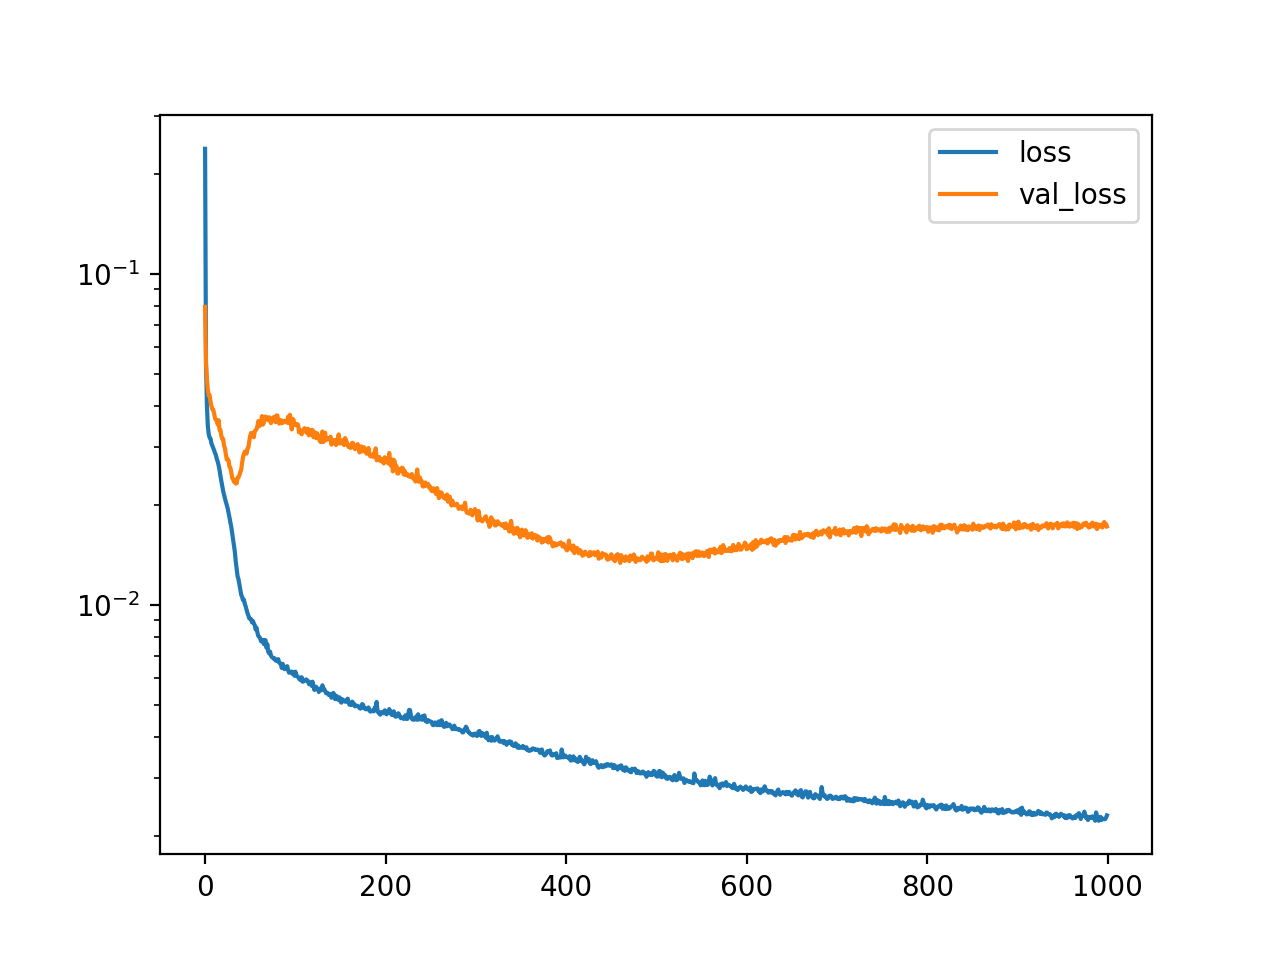

In [63]:
fig, ax = plt.subplots()
ax.semilogy(history.history['loss'], label='loss')
ax.semilogy(history.history['val_loss'], label='val_loss')
ax.legend()

# Evaluate Model


In [64]:
test_with = 2
nn_input_i = nn_input_test[test_with]
nn_output_i = nn_output_test[test_with]


res = []

for i,in_i in nn_input_i.iterrows():
    nn_in = in_i.to_numpy()
    nn_out = model.predict(nn_in.reshape(1,-1))*Y_train_scaling
    res.append(nn_out)
res = np.concatenate(res, axis=0).squeeze()

In [65]:
res_df = pd.DataFrame(res, columns = nn_output_i.keys())

<IPython.core.display.Javascript object>


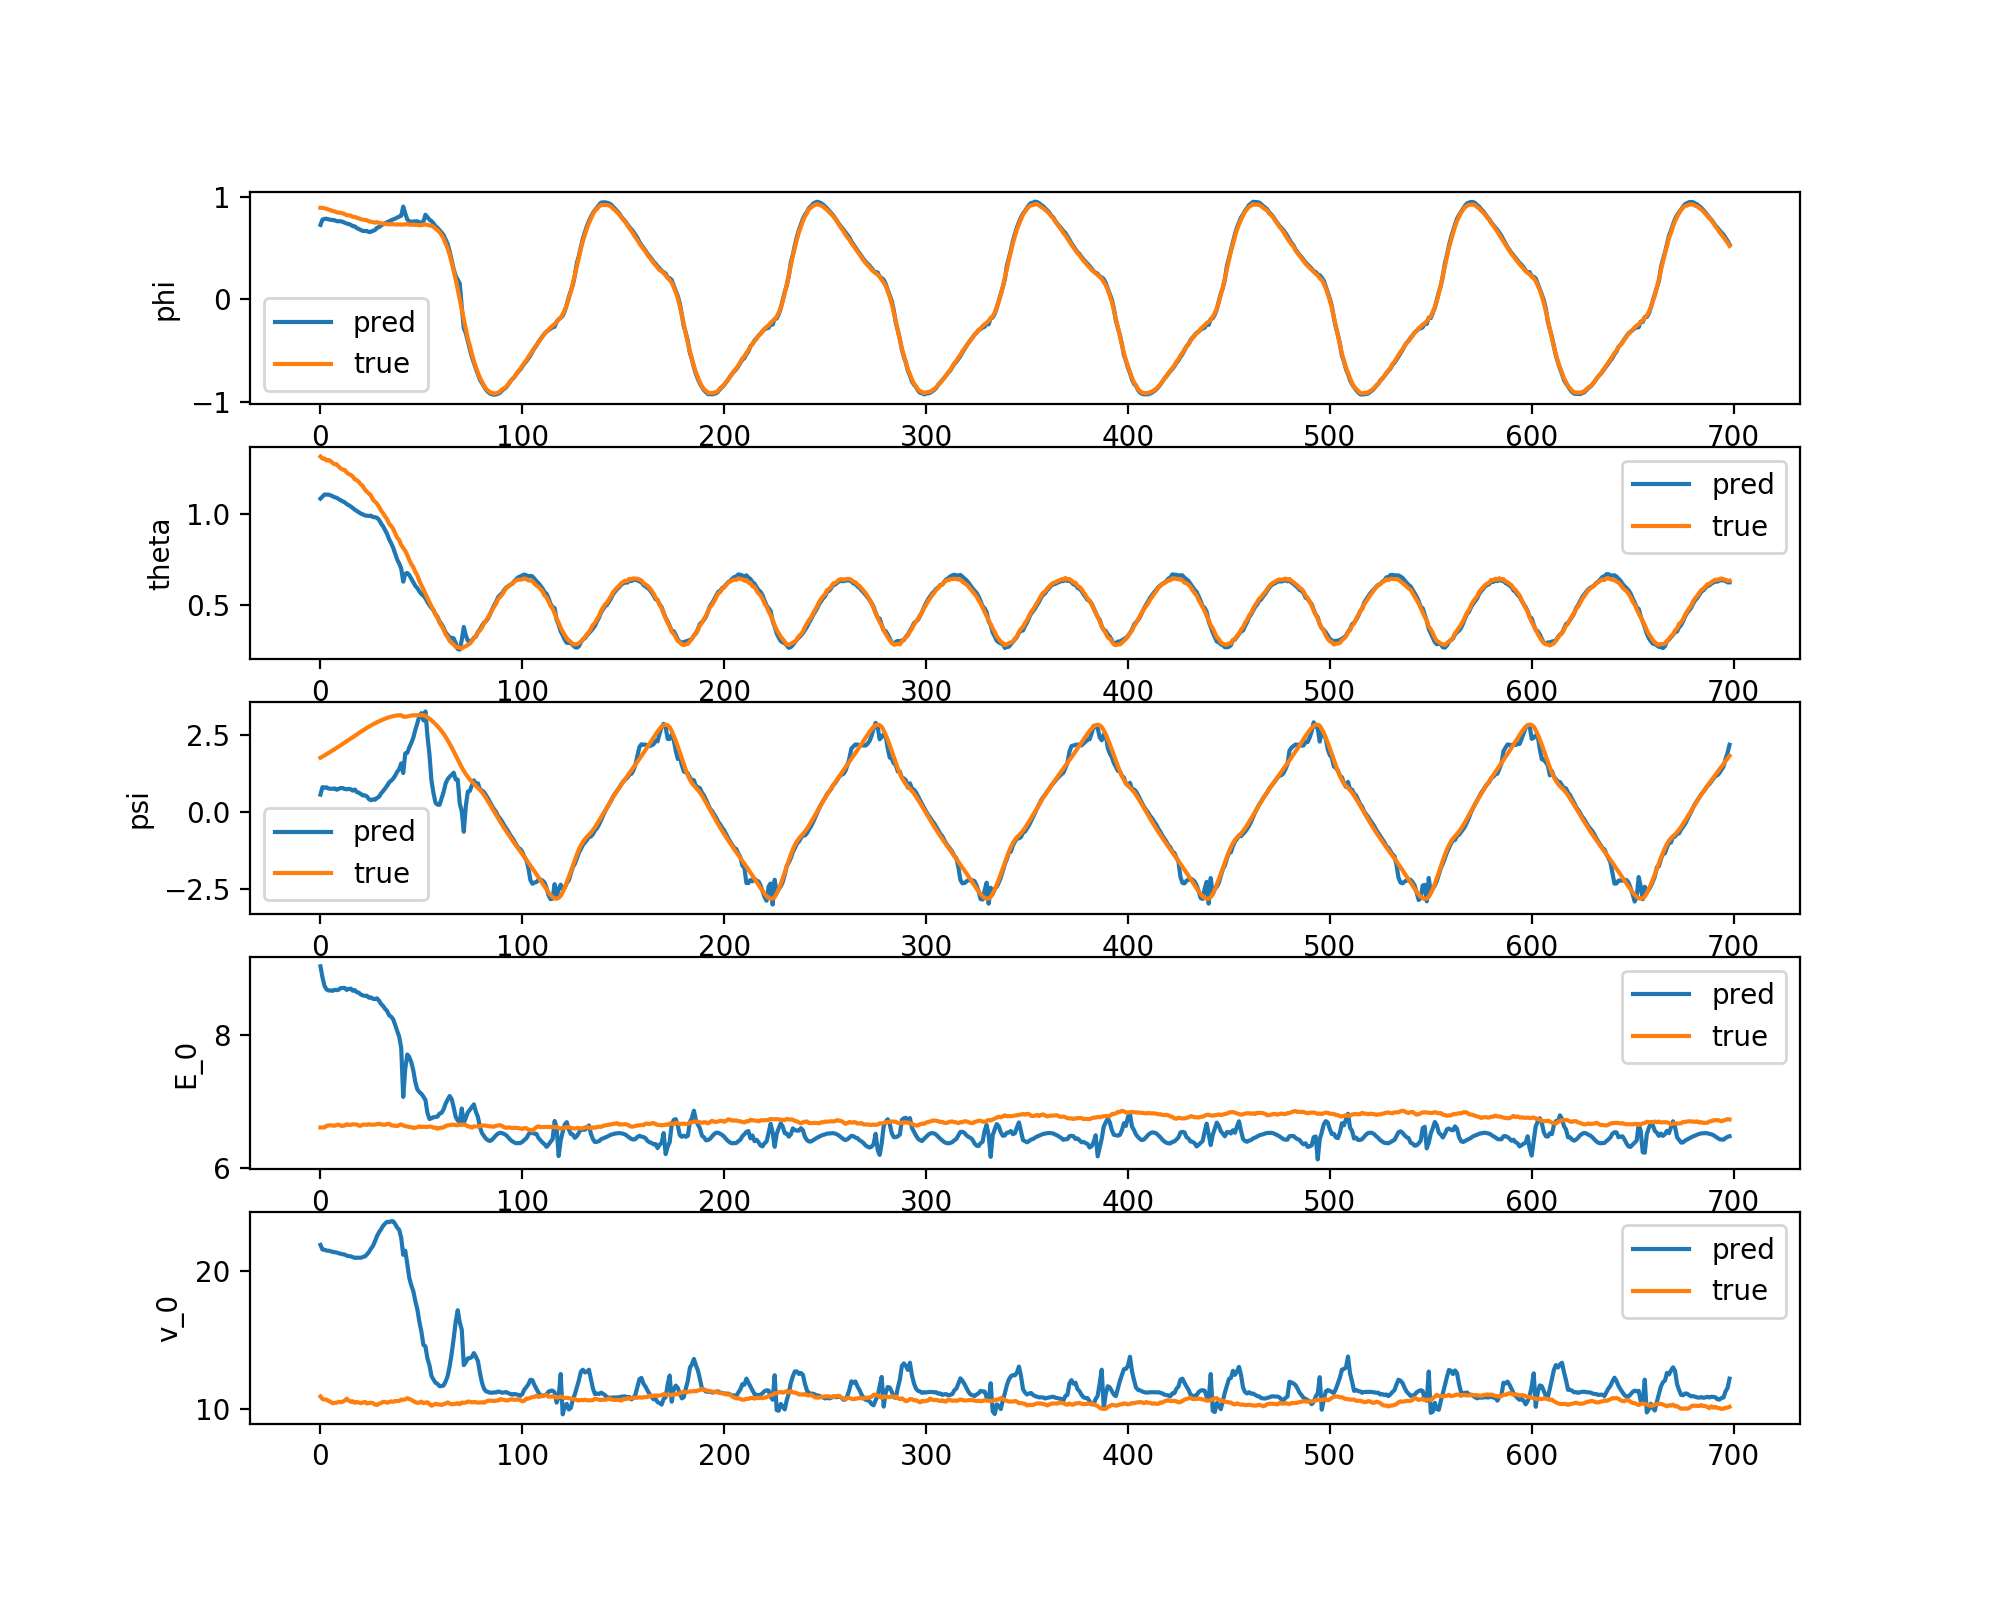

Text(0, 0.5, 'v_0')

In [66]:
fig, ax = plt.subplots(5, figsize=(10,8))

res_df.plot(y=['phi'], ax=ax[0], label=['pred'])
nn_output_i.plot(y=['phi'], ax=ax[0], label=['true'])
ax[0].set_ylabel('phi')

res_df.plot(y=['theta'], ax=ax[1], label=['pred'])
nn_output_i.plot(y=['theta'], ax=ax[1], label=['true'])
ax[1].set_ylabel('theta')

res_df.plot(y=['psi'], ax=ax[2], label=['pred'])
nn_output_i.plot(y=['psi'], ax=ax[2], label=['true'])
ax[2].set_ylabel('psi')

res_df.plot(y=['E_0'], ax=ax[3], label=['pred'])
nn_output_i.plot(y=['E_0'], ax=ax[3], label=['true'])
ax[3].set_ylabel('E_0')

res_df.plot(y=['v_0'], ax=ax[4], label=['pred'])
nn_output_i.plot(y=['v_0'], ax=ax[4], label=['true'])
ax[4].set_ylabel('v_0')